<a href="https://colab.research.google.com/github/Priyanshumg/Portfolio-Risk-Calculation/blob/main/Portfolio_Risk_Calculator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 📊 Portfolio Risk Calculator (Python)
A clean, reusable risk calculator for a multi-asset portfolio. It downloads historical prices, computes **daily returns**, and calculates:
- **Annualized Volatility**
- **Annualized Sharpe Ratio** (excess over a risk-free rate)
- **Historical VaR & CVaR (Expected Shortfall)**
- **Parametric (Normal) VaR**
- Visualizations: prices, cumulative returns, histogram with VaR threshold, rolling volatility

> Built to run on **Google Colab** using only NumPy, Pandas, Matplotlib (and yfinance for data).



In [ ]:
!pip -q install yfinance --upgrade

import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from scipy.stats import norm
from datetime import datetime

pd.set_option('display.float_format', lambda x: f'{x:,.6f}')

## 2) User Inputs
Edit these values to match your portfolio and preferences.


In [ ]:
# === User Inputs ===
# Tickers and weights
TICKERS = ['AAPL', 'MSFT', 'GOOGL']
WEIGHTS = np.array([0.40, 0.30, 0.30])

START = '2018-01-01'
END = None

# Risk & VaR settings
RISK_FREE_ANNUAL = 0.045
VAR_LEVEL = 0.95
HOLDING_PERIOD_DAYS = 1

# Reporting
INITIAL_CAPITAL = 100000

# Basic validation
assert len(TICKERS) == len(WEIGHTS), "TICKERS and WEIGHTS length mismatch."
assert abs(WEIGHTS.sum() - 1.0) < 1e-8, "WEIGHTS must sum to 1."

TRADING_DAYS = 252
RISK_FREE_DAILY = (1 + RISK_FREE_ANNUAL)**(1/TRADING_DAYS) - 1
print(f"Daily risk-free ≈ {RISK_FREE_DAILY:.6f}")

Daily risk-free ≈ 0.000175


## 3) Download & Prepare Data
Uses `yfinance` to fetch **adjusted close** prices and compute daily returns.


In [ ]:
def fetch_prices(tickers, start, end):
    data = yf.download(tickers, start=start, end=end, auto_adjust=True, progress=False)
    if 'Close' in data:
        prices = data['Close']
    else:
        prices = data
    if isinstance(prices, pd.Series):
        prices = prices.to_frame()
    prices = prices.dropna(how='any')
    return prices

prices = fetch_prices(TICKERS, START, END)
print(f"Fetched {prices.shape[0]} rows from {prices.index.min().date()} to {prices.index.max().date()}")
print(f"Prices shape: {prices.shape}")
display(prices.tail())

Fetched 1917 rows from 2018-01-02 to 2025-08-18
Prices shape: (1917, 3)


Ticker,AAPL,GOOGL,MSFT
Date,,,
2025-08-12,229.649994,203.339996,529.239990
2025-08-13,233.330002,201.960007,520.580017
2025-08-14,232.779999,202.940002,522.479980
2025-08-15,231.589996,203.899994,520.169983
2025-08-18,230.889999,203.500000,517.099976


## 4) Compute Returns & Core Portfolio Metrics
- Daily returns per asset
- Portfolio expected return/volatility (annualized)
- Annualized Sharpe


In [ ]:
# Daily returns
returns = prices.pct_change().dropna()
returns.shape

(1916, 3)

In [ ]:
# Portfolio daily return series
port_ret = returns.dot(WEIGHTS)
port_ret.tail()

,0
Date,
2025-08-12,0.012136
2025-08-13,-0.000535
2025-08-14,0.001608
2025-08-15,-0.001952
2025-08-18,-0.003568


In [ ]:
# Excess returns over daily risk-free
excess_port_ret = port_ret - RISK_FREE_DAILY
excess_port_ret.tail()

,0
Date,
2025-08-12,0.011962
2025-08-13,-0.000710
2025-08-14,0.001433
2025-08-15,-0.002127
2025-08-18,-0.003743


In [ ]:
# Mean vector & covariance (daily)
mean_daily = returns.mean()
cov_daily = returns.cov()

# Portfolio expected return & volatility (daily)
exp_port_daily = float(mean_daily.values @ WEIGHTS)
vol_port_daily = float(np.sqrt(WEIGHTS.T @ cov_daily.values @ WEIGHTS))

# Annualize
exp_port_annual = exp_port_daily * TRADING_DAYS
vol_port_annual = vol_port_daily * np.sqrt(TRADING_DAYS)
sharpe_annual = (exp_port_annual - RISK_FREE_ANNUAL) / vol_port_annual

print("Annualized metrics:")
print(f"  Expected Return: {exp_port_annual:.4%}")
print(f"  Volatility     : {vol_port_annual:.4%}")
print(f"  Sharpe Ratio   : {sharpe_annual:.3f}")


Annualized metrics:
  Expected Return: 26.4884%
  Volatility     : 27.0859%
  Sharpe Ratio   : 0.812


## 5) VaR & CVaR (Historical and Parametric)
- **Historical VaR/CVaR** from empirical distribution of excess returns
- **Parametric VaR** assuming Normal distribution for excess returns


In [ ]:
alpha = VAR_LEVEL

# Historical VaR/CVaR
q = np.percentile(excess_port_ret, (1 - alpha) * 100)   # left-tail percentile of excess returns
hist_VaR_1d = -q                                       # report as +ve loss
hist_CVaR_1d = -excess_port_ret[excess_port_ret <= q].mean()

# Parametric (Normal) VaR on excess returns
mu_e = excess_port_ret.mean()
sigma_e = excess_port_ret.std(ddof=1)
VaR_norm_1d = -(mu_e + sigma_e * np.percentile([0], 100*(1-alpha)).item() if False else (mu_e + sigma_e * 0))  # placeholder, replaced below

# Proper z-value using SciPy
from scipy.stats import norm
VaR_norm_1d = -(mu_e + sigma_e * norm.ppf(1 - alpha))  # left tail

# Scale to holding period
t = HOLDING_PERIOD_DAYS
hist_VaR_t = hist_VaR_1d * np.sqrt(t)
hist_CVaR_t = hist_CVaR_1d * np.sqrt(t)
VaR_norm_t = VaR_norm_1d * np.sqrt(t)

# Currency terms
hist_VaR_amt = INITIAL_CAPITAL * hist_VaR_t
hist_CVaR_amt = INITIAL_CAPITAL * hist_CVaR_t
norm_VaR_amt = INITIAL_CAPITAL * VaR_norm_t

summary = pd.Series({
    'Start': str(returns.index[0].date()),
    'End': str(returns.index[-1].date()),
    'Tickers': ','.join(TICKERS),
    'Weights': ','.join([f'{w:.2%}' for w in WEIGHTS]),
    'Exp Return (annual)': exp_port_annual,
    'Volatility (annual)': vol_port_annual,
    'Sharpe (annual)': sharpe_annual,
    f'Hist VaR {int(alpha*100)}% ({t}d)': hist_VaR_t,
    f'Parametric VaR {int(alpha*100)}% ({t}d)': VaR_norm_t,
    f'Hist CVaR {int(alpha*100)}% ({t}d)': hist_CVaR_t,
    f'Hist VaR Amt {int(alpha*100)}% ({t}d)': hist_VaR_amt,
    f'Parametric VaR Amt {int(alpha*100)}% ({t}d)': norm_VaR_amt,
    f'Hist CVaR Amt {int(alpha*100)}% ({t}d)': hist_CVaR_amt
})

display(summary.to_frame('value'))


,value
Start,2018-01-03
End,2025-08-18
Tickers,"AAPL,MSFT,GOOGL"
Weights,"40.00%,30.00%,30.00%"
Exp Return (annual),0.264884
Volatility (annual),0.270859
Sharpe (annual),0.811803
Hist VaR 95% (1d),0.026782
Parametric VaR 95% (1d),0.027189
Hist CVaR 95% (1d),0.039369


## 6) Visualizations (Matplotlib only)
- Adjusted close prices
- Cumulative returns (assets + portfolio)
- Histogram of daily **excess** returns with VaR line
- Rolling annualized volatility (21d)


Text(58.347222222222214, 0.5, 'Volatility')

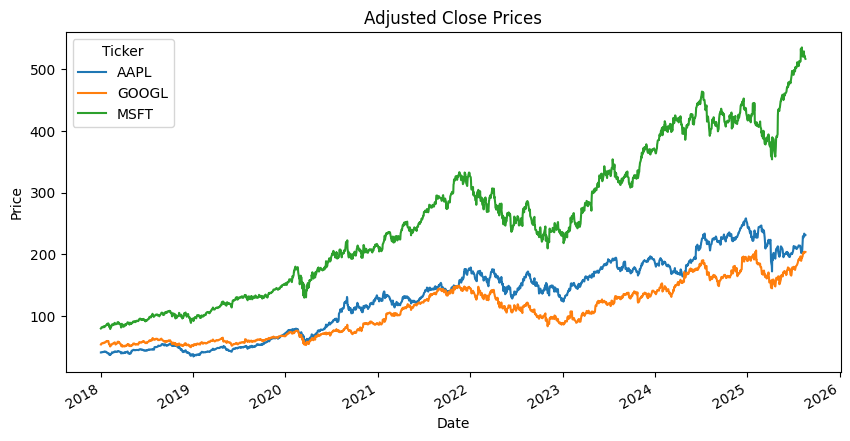

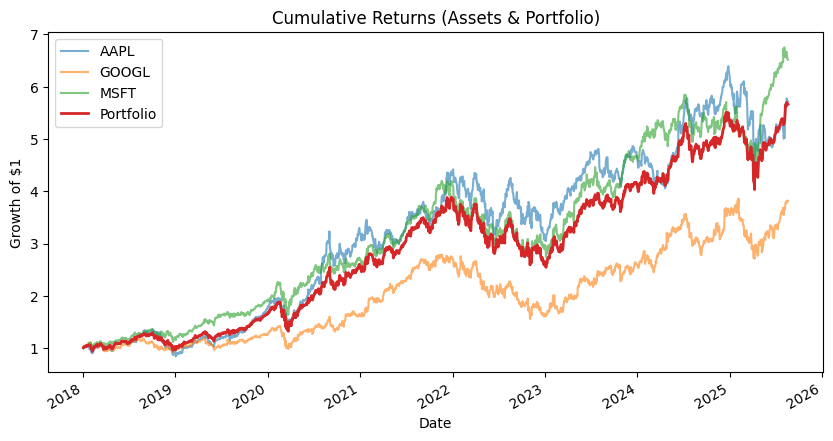

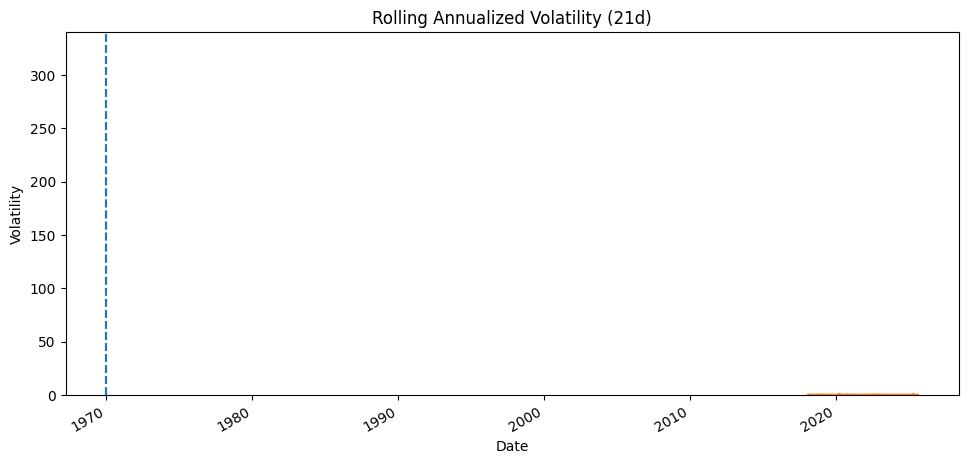

In [ ]:
# Price history
ax = prices.plot(figsize=(10,5), title='Adjusted Close Prices')
ax.set_xlabel('Date'); ax.set_ylabel('Price')

# Cumulative returns
cum_assets = (1 + returns).cumprod()
cum_port = (1 + port_ret).cumprod()

ax = cum_assets.plot(figsize=(10,5), alpha=0.6)
cum_port.plot(ax=ax, linewidth=2)
ax.set_title('Cumulative Returns (Assets & Portfolio)')
ax.set_xlabel('Date'); ax.set_ylabel('Growth of $1')
ax.legend(list(returns.columns) + ['Portfolio'])

# Histogram with VaR marker
import matplotlib.pyplot as plt
plt.figure(figsize=(8,5))
plt.hist(excess_port_ret, bins=50)
plt.axvline(x=np.percentile(excess_port_ret, (1 - VAR_LEVEL) * 100), linestyle='--')
plt.axvline(x=excess_port_ret.mean(), linestyle='--')
plt.title(f'Portfolio Daily Excess Returns | {int(VAR_LEVEL*100)}% VaR')
plt.xlabel('Daily Excess Return')
plt.ylabel('Frequency')
plt.tight_layout()

# Rolling (21d) annualized volatility
rolling_vol = port_ret.rolling(21).std() * np.sqrt(252)
ax = rolling_vol.plot(figsize=(10,5), title='Rolling Annualized Volatility (21d)')
ax.set_xlabel('Date'); ax.set_ylabel('Volatility')


## 7) Save Outputs (CSVs)
Saves a summary and return series in the Colab working directory.


In [ ]:
out_dir = '/content'  # Colab default
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')

summary.to_csv(f'{out_dir}/portfolio_risk_summary_{timestamp}.csv')
returns.to_csv(f'{out_dir}/asset_daily_returns_{timestamp}.csv')
port_ret.to_frame('portfolio_return').to_csv(f'{out_dir}/portfolio_daily_returns_{timestamp}.csv')

print('Saved to:', out_dir)

Saved to: /content


## 8) (Optional) Simulated Efficient Frontier
Random portfolios to visualize risk/return tradeoffs and max Sharpe estimate.


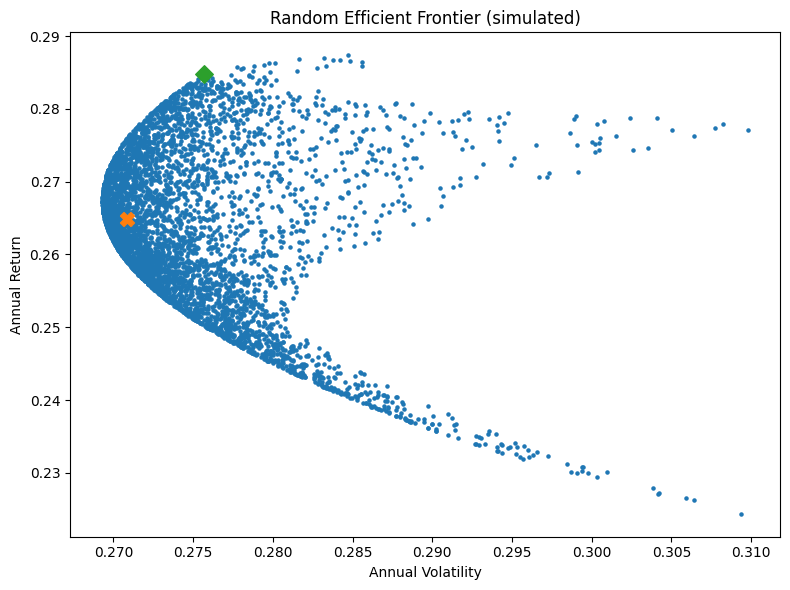

Max Sharpe portfolio (simulated) weights:
Ticker
AAPL     30.94%
GOOGL     0.25%
MSFT     68.82%
dtype: object


In [ ]:
def simulate_frontier(returns_df, n_portfolios=5000, rf=RISK_FREE_ANNUAL):
    mean_daily = returns_df.mean().values
    cov = returns_df.cov().values
    results = []
    weights_list = []
    for _ in range(n_portfolios):
        w = np.random.rand(len(mean_daily))
        w = w / w.sum()
        mu = (w @ mean_daily) * 252
        vol = np.sqrt(w @ cov @ w) * np.sqrt(252)
        sharpe = (mu - rf) / vol
        results.append((vol, mu, sharpe))
        weights_list.append(w)
    res = pd.DataFrame(results, columns=['vol','ret','sharpe'])
    return res, np.array(weights_list)

frontier, ws = simulate_frontier(returns, n_portfolios=5000)
best_idx = frontier['sharpe'].idxmax()
best = frontier.loc[best_idx]
best_w = ws[best_idx]

plt.figure(figsize=(8,6))
plt.scatter(frontier['vol'], frontier['ret'], s=5)
plt.scatter([vol_port_annual], [exp_port_annual], marker='X', s=100)
plt.scatter([best['vol']], [best['ret']], marker='D', s=80)
plt.title('Random Efficient Frontier (simulated)')
plt.xlabel('Annual Volatility')
plt.ylabel('Annual Return')
plt.tight_layout()
plt.show()

print('Max Sharpe portfolio (simulated) weights:')
print(pd.Series(best_w, index=returns.columns).apply(lambda x: f'{x:.2%}'))
